In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.date).order_by(Measurement.date.desc())
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date = end_date[0]
end_date
# Calculate the date 1 year ago from the last data point in the database
day_year_before = dt.datetime.strptime(end_date, "%Y-%m-%d")- dt.timedelta(days=365)
day_year_before

# Perform a query to retrieve the data and precipitation scores
query_for_prcp_data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=day_year_before).all()

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(query_for_prcp_data, columns = ["date", "precipitation"])
prcp_df.set_index("date", inplace = True)

# Sort the dataframe by date
prcp_df.sort_values("date", ascending=False)

,precipitation
date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.00
...,...
2016-08-24,1.22
2016-08-24,1.45
2016-08-24,2.15


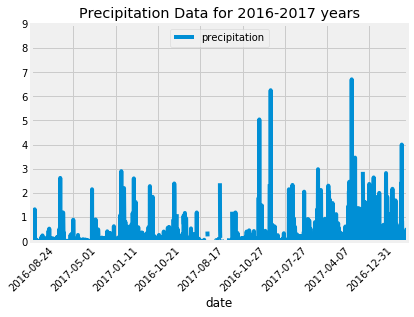

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation Data for 2016-2017 years")
plt.legend(loc="upper center")
plt.ylim(0,9)
plt.xticks(rotation = 45)
plt.savefig("Images/Precipitation.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = most_active_stations[0][0]

temp_min_max_avg = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
temp_min_max_avg

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Choose the station with the highest number of temperature observations.
station_max_obs = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
station_max_obs = station_max_obs [0]
station_max_obs


'USC00519281'

In [18]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_for_temp_data=session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>=day_year_before, Measurement.station == station_max_obs).all()
query_for_temp_data
temp_df = pd.DataFrame(query_for_temp_data, columns = ["date", "temperatures"])
temp_df.set_index("date", inplace = True)
temp_df

,temperatures
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


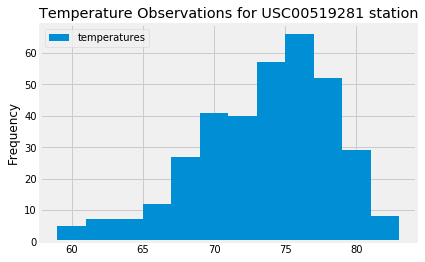

In [19]:
temp_df.plot.hist(bins=12, title="Temperature Observations for " + str(station_max_obs) + " station")
plt.savefig("Images/Temperatures.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = dt.date(2018,2,14)
trip_end_date = dt.date(2018,3,1)
one_year = dt.timedelta(days=365)
start_date_year_ago = trip_start_date-one_year
end_date_year_ago = trip_end_date-one_year

print(calc_temps(start_date_year_ago, end_date_year_ago))


[(61.0, 70.73737373737374, 79.0)]


In [22]:
trip_temp_results = calc_temps(start_date_year_ago, end_date_year_ago)

In [23]:
trip_temp_results_df = pd.DataFrame(trip_temp_results, columns=['Temperature Minimum (°F)','Temperature Average (°F)','Temperature Maximum (°F)'])
trip_temp_results_df

,Temperature Minimum (°F),Temperature Average (°F),Temperature Maximum (°F)
0,61.0,70.737374,79.0


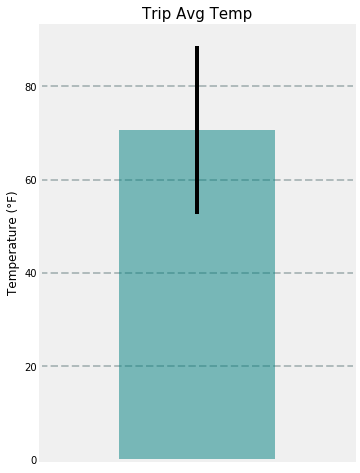

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tavg = trip_temp_results_df['Temperature Average (°F)']
tdifference = trip_temp_results_df.iloc[0]['Temperature Maximum (°F)'] - trip_temp_results_df.iloc[0]['Temperature Minimum (°F)']
tavg.plot(kind='bar', yerr=tdifference, figsize=(5,8), alpha=0.5, color='teal')
plt.title("Trip Avg Temp", fontsize=15)
plt.ylabel("Temperature (°F)")
plt.xticks([])
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.savefig("Images/Trip_Temperatures.png")
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.

prcp_trip_dates_query = session.query(Measurement.station, Measurement.date,Measurement.prcp).filter(Measurement.date>=start_date_year_ago, Measurement.date<=end_date_year_ago).all()

In [26]:
# Sort this in descending order by precipitation amount and list 
# the station, name, latitude, longitude, and elevation
prcp_trip_dates_df= pd.DataFrame(prcp_trip_dates_query, columns=['Station', 'Date', 'Precipitation'])
prcp_trip_dates_df

,Station,Date,Precipitation
0,USC00519397,2017-02-14,0.00
1,USC00519397,2017-02-15,0.00
2,USC00519397,2017-02-16,0.07
3,USC00519397,2017-02-17,0.00
4,USC00519397,2017-02-18,0.00
...,...,...,...
94,USC00516128,2017-02-25,0.12
95,USC00516128,2017-02-26,0.00
96,USC00516128,2017-02-27,0.00
97,USC00516128,2017-02-28,0.58


In [27]:
prcp_trip_dates_sorted_df = prcp_trip_dates_df.sort_values('Station')
prcp_trip_dates_sorted_df

,Station,Date,Precipitation
24,USC00513117,2017-02-22,0.06
26,USC00513117,2017-02-24,0.00
25,USC00513117,2017-02-23,0.00
29,USC00513117,2017-02-27,0.00
23,USC00513117,2017-02-21,0.00
...,...,...,...
63,USC00519523,2017-02-24,0.00
64,USC00519523,2017-02-26,NaN
65,USC00519523,2017-02-27,0.00
66,USC00519523,2017-02-28,0.00


In [28]:
prcp_trip_grouped_df = prcp_trip_dates_sorted_df.groupby(["Station"])
prcp_trip_grouped_df.head()

,Station,Date,Precipitation
24,USC00513117,2017-02-22,0.06
26,USC00513117,2017-02-24,0.00
25,USC00513117,2017-02-23,0.00
29,USC00513117,2017-02-27,0.00
23,USC00513117,2017-02-21,0.00
33,USC00514830,2017-02-15,0.00
34,USC00514830,2017-02-16,0.62
35,USC00514830,2017-02-17,0.06
36,USC00514830,2017-02-20,NaN
37,USC00514830,2017-02-21,0.00


In [29]:
prcp_trip_grouped_sum = prcp_trip_grouped_df["Precipitation"].sum()
prcp_trip_grouped_sum_df = pd.DataFrame(prcp_trip_grouped_sum)
prcp_trip_grouped_sum_sorted_df = prcp_trip_grouped_sum_df.sort_values('Precipitation', ascending=False)

In [30]:
prcp_trip_grouped_sum_sorted_df

,Precipitation
Station,
USC00516128,3.40
USC00513117,3.22
USC00519281,3.18
USC00517948,2.57
USC00514830,1.95
USC00519523,1.46
USC00519397,1.42


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


query_for_station_data=session.query(Station.station,Station.name,Station.latitude,Station.longitude, Station.elevation)
station_data_df = pd.DataFrame(query_for_station_data, columns=['Station', 'Station Name', 'Latitude', 'Longitude', 'Elevation'])
merge_table = pd.merge(prcp_trip_grouped_sum_sorted_df, station_data_df, on="Station")
merge_table = merge_table[['Station', 'Station Name', 'Latitude', 'Longitude', 'Elevation','Precipitation']]
merge_table


,Station,Station Name,Latitude,Longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.40
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.18
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.57
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.95
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.46
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.42


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).\
        filter(Measurement.date >= start_date_year_ago).\
        filter(Measurement.date <= end_date_year_ago).\
        group_by(Measurement.date).all()

dates

[('2017-02-14'),
 ('2017-02-15'),
 ('2017-02-16'),
 ('2017-02-17'),
 ('2017-02-18'),
 ('2017-02-19'),
 ('2017-02-20'),
 ('2017-02-21'),
 ('2017-02-22'),
 ('2017-02-23'),
 ('2017-02-24'),
 ('2017-02-25'),
 ('2017-02-26'),
 ('2017-02-27'),
 ('2017-02-28'),
 ('2017-03-01')]

In [34]:
dates_list = [date[0] for date in dates]
dates_list

['2017-02-14',
 '2017-02-15',
 '2017-02-16',
 '2017-02-17',
 '2017-02-18',
 '2017-02-19',
 '2017-02-20',
 '2017-02-21',
 '2017-02-22',
 '2017-02-23',
 '2017-02-24',
 '2017-02-25',
 '2017-02-26',
 '2017-02-27',
 '2017-02-28',
 '2017-03-01']

In [35]:
# Stip off the year and save a list of %m-%d strings
mm_dd_list = [date[5:10] for date in dates_list]
mm_dd_list

['02-14',
 '02-15',
 '02-16',
 '02-17',
 '02-18',
 '02-19',
 '02-20',
 '02-21',
 '02-22',
 '02-23',
 '02-24',
 '02-25',
 '02-26',
 '02-27',
 '02-28',
 '03-01']

In [36]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = [daily_normals(mm_dd) for mm_dd in mm_dd_list]
dnormals = [item[0] for item in normals_list]
dnormals

[(62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0),
 (59.0, 70.48214285714286, 76.0),
 (62.0, 70.47272727272727, 77.0),
 (63.0, 70.79629629629629, 77.0),
 (60.0, 69.33962264150944, 77.0),
 (63.0, 70.14035087719299, 76.0),
 (63.0, 69.79629629629629, 76.0),
 (60.0, 70.15789473684211, 83.0),
 (62.0, 70.35593220338983, 81.0),
 (61.0, 68.56666666666666, 76.0),
 (61.0, 68.59649122807018, 76.0),
 (62.0, 69.89285714285714, 78.0),
 (58.0, 69.98148148148148, 77.0),
 (65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0)]

In [37]:
dates_df = pd.DataFrame(dates_list, columns=['date'])
dates_df

,date
0,2017-02-14
1,2017-02-15
2,2017-02-16
3,2017-02-17
4,2017-02-18
5,2017-02-19
6,2017-02-20
7,2017-02-21
8,2017-02-22
9,2017-02-23


In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df=pd.DataFrame(dnormals, columns=['tmin','tavg', 'tmax'])
daily_normals_df

,tmin,tavg,tmax
0,62.0,70.894737,79.0
1,56.0,70.288136,79.0
2,59.0,70.482143,76.0
3,62.0,70.472727,77.0
4,63.0,70.796296,77.0
5,60.0,69.339623,77.0
6,63.0,70.140351,76.0
7,63.0,69.796296,76.0
8,60.0,70.157895,83.0
9,62.0,70.355932,81.0


In [39]:
summary_daily_normals_df=pd.merge(dates_df, daily_normals_df, left_index=True, right_index=True)
summary_daily_normals_df

,date,tmin,tavg,tmax
0,2017-02-14,62.0,70.894737,79.0
1,2017-02-15,56.0,70.288136,79.0
2,2017-02-16,59.0,70.482143,76.0
3,2017-02-17,62.0,70.472727,77.0
4,2017-02-18,63.0,70.796296,77.0
5,2017-02-19,60.0,69.339623,77.0
6,2017-02-20,63.0,70.140351,76.0
7,2017-02-21,63.0,69.796296,76.0
8,2017-02-22,60.0,70.157895,83.0
9,2017-02-23,62.0,70.355932,81.0


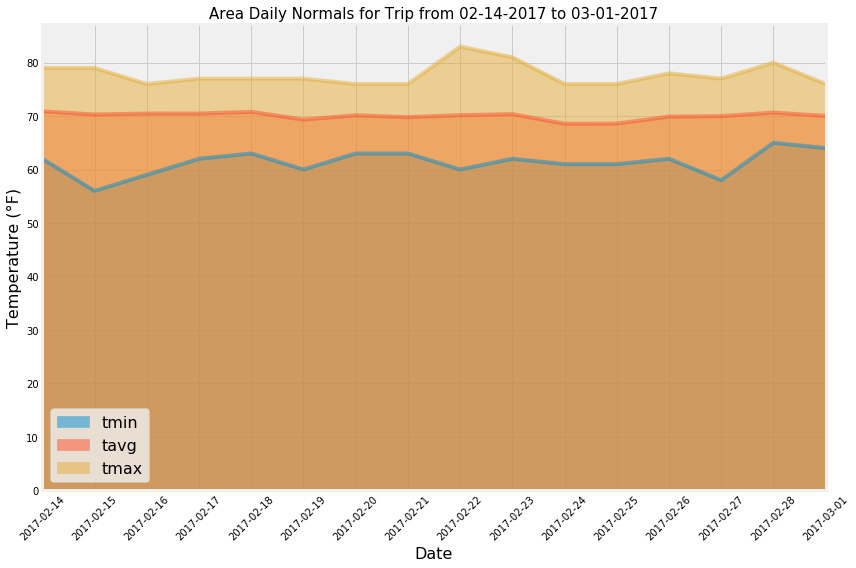

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
x = np.arange(0,len(summary_daily_normals_df))
summary_daily_normals_df.plot.area(stacked = False, alpha = 0.5, figsize = (12,8))
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Temperature (°F)", fontsize = 16)
plt.xticks(x, dates_list, rotation = 45)
plt.legend(fontsize = 16)
plt.title("Area Daily Normals for Trip from 02-14-2017 to 03-01-2017", fontsize=15)
plt.tight_layout()
plt.savefig("Images/Trip_Area_Daily_Normals.png")